In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# from hipe4ml.model_handler import ModelHandler
# from hipe4ml.tree_handler import TreeHandler
# from hipe4ml.analysis_utils import train_test_generator
# from hipe4ml import plot_utils, analysis_utils
import ROOT

In [2]:
def clean_name(name):
    name = name.replace("MC", "")
    name = name.replace(" ", "")
    name = name.replace("(GeV/c)", "")
    name = name.replace("#", "")
    return name

def hist_to_df(hist, clean_names=True):  # For pyROOT histograms
    """
    Convert a TH1 or TH2 histogram to a pandas DataFrame.
    If clean_names=True, removes spaces and 'MC' from axis names.
    """

    if hist.ClassName().startswith("TH1"):
        nbins = hist.GetNbinsX()
        edges = np.array([hist.GetBinLowEdge(i) for i in range(1, nbins+2)])
        values = np.array([hist.GetBinContent(i) for i in range(1, nbins+1)])

        x_name = hist.GetXaxis().GetTitle()
        if clean_names:
            x_name = clean_name(x_name)

        return pd.DataFrame({
            f"{x_name}_left": edges[:-1],
            f"{x_name}_right": edges[1:],
            "counts": values
        })

    elif hist.ClassName().startswith("TH2"):
        nx = hist.GetNbinsX()
        ny = hist.GetNbinsY()
        x_edges = np.array([hist.GetXaxis().GetBinLowEdge(i) for i in range(1, nx+2)])
        y_edges = np.array([hist.GetYaxis().GetBinLowEdge(i) for i in range(1, ny+2)])

        data = []
        for i in range(1, nx+1):
            for j in range(1, ny+1):
                x_left, x_right = x_edges[i-1], x_edges[i]
                y_left, y_right = y_edges[j-1], y_edges[j]
                count = hist.GetBinContent(i, j)
                data.append([x_left, x_right, y_left, y_right, count])

        x_name = hist.GetXaxis().GetTitle()
        y_name = hist.GetYaxis().GetTitle()
        if clean_names:
            x_name = clean_name(x_name)
            y_name = clean_name(y_name)

        columnsNames = [f"{x_name}_left", f"{x_name}_right", f"{y_name}_left", f"{y_name}_right", "counts"]
        return pd.DataFrame(data, columns=columnsNames)

    else:
        raise NotImplementedError(f"Only TH1 and TH2 supported, but got {hist.ClassName()}")
    
def rebin_df(df, new_edges, x_left="x_left", x_right="x_right", counts="counts"):
    new_counts = []
    
    for i in range(len(new_edges)-1):
        bin_left = new_edges[i]
        bin_right = new_edges[i+1]
        # Select all original bins that overlap the new bin
        mask = (df[x_right] > bin_left) & (df[x_left] < bin_right)
        
        # Sum the counts of overlapping bins (simple sum; more precise weighting can be applied if needed)
        new_counts.append(df.loc[mask, counts].sum())
        
    return pd.DataFrame({
        "bin_left": new_edges[:-1],
        "bin_right": new_edges[1:],
        "counts": new_counts
    })

def df_to_root_graph(df, graph_name="graph", graph_title="Histogram with errors", yerr=None):
    """
    Convert a pandas DataFrame with 'bin_left', 'bin_right', 'counts' to a ROOT TGraphErrors
    with horizontal error bars corresponding to bin widths.
    """
    bin_left = df["bin_left"].values
    bin_right = df["bin_right"].values
    counts = df["counts"].values

    x = (bin_left + bin_right) / 2.0           # bin centers
    y = counts
    ex = (bin_right - bin_left) / 2.0          # horizontal errors = half bin width
    # ey = np.sqrt(counts)                        # vertical errors (Poisson), can set to 0 if not needed
    ey=np.zeros_like(y)  # No vertical errors, can be set to zero
    if yerr is not None:
        ey = yerr              # vertical errors from DataFrame if provided
    graph = ROOT.TGraphErrors(len(x),
                              x.astype(float), y.astype(float),
                              ex.astype(float), ey.astype(float))
    graph.SetName(graph_name)
    graph.SetTitle(graph_title)
    graph.SetMarkerStyle(20)
    # graph.SetMarkerSize(0.8)

    return graph

def EfficiencyPlot(a, b, path, graph_title, legText, ptBins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 12]):
    root_file = ROOT.TFile.Open(path)    
    output_dir_name = 'analysis-same-event-pairing/output;1'
    output_dir = root_file.Get(output_dir_name)
    if not output_dir:
        print(f"{output_dir_name} not found in the ROOT file.")

    aList = None
    bList = None
    for JPsiList in output_dir:
        # print("JPsiList: ", JPsiList.GetName())
        if JPsiList.GetName() == a:
            aList = JPsiList
        elif JPsiList.GetName() == b:
            bList = JPsiList
    if not aList:
        print(f"{a} not found in the output directory!")
    if not bList:
        print(f"{b} not found in the output directory!")

    df_a = None
    df_b = None

    for hist in aList:
        if "Truth" in a:
            if hist.GetName() == "EtaMC_PtMC":
                df_a = hist_to_df(hist, clean_names=True)
        else:
            if hist.GetName() == "Eta_Pt":
                df_a = hist_to_df(hist, clean_names=True)
    for hist in bList:
        if "Truth" in b:
            if hist.GetName() == "EtaMC_PtMC":
                df_b = hist_to_df(hist, clean_names=True)
        else:
            if hist.GetName() == "Eta_Pt":
                df_b = hist_to_df(hist, clean_names=True)
    
    # filter out |eta| > 0.9
    df_aFilt = df_a[~((df_a["eta_left"] < -0.9001) | (df_a["eta_right"] > 0.9001))] # 0.9001 due to floating-point error
    df_bFilt = df_b[~((df_b["eta_left"] < -0.9001) | (df_b["eta_right"] > 0.9001))]

    df_aFiltReb = rebin_df(df_aFilt, ptBins, x_left="p_{T}_left", x_right="p_{T}_right", counts="counts")
    df_bFiltReb = rebin_df(df_bFilt, ptBins, x_left="p_{T}_left", x_right="p_{T}_right", counts="counts")

    df_eff = df_aFiltReb.copy()
    df_eff['counts'] = df_eff['counts'] / df_bFiltReb['counts']

    # Statistical Uncertainty
    eff_statUnc = np.sqrt(df_eff['counts'] * (1 - df_eff['counts']) / df_bFiltReb['counts']) # Binomial uncertainty
    graph = df_to_root_graph(df_eff, "efficiency_graph", graph_title, yerr=np.array(eff_statUnc))
    ROOT.SetOwnership(graph, True)
    graph.GetXaxis().SetTitle("p_{T} (GeV/c)")
    graph.GetYaxis().SetTitle("A x #epsilon")
    graph.SetMarkerColor(ROOT.kRed-2)
    graph.SetLineColor(ROOT.kRed-2)
    graph.SetLineWidth(2)

    legend = ROOT.TLegend(0.55, 0.7, 0.9, 0.9)
    legend.AddEntry(legend,"pp @ 13.6 TeV", "")
    legend.AddEntry(graph, legText, "p")
    legend.SetFillStyle(0)
    legend.SetBorderSize(0)
    legend.SetTextSize(0.04)

    output_dir.Delete()
    root_file.Close()
    root_file.Delete()

    return graph, legend

In [3]:
dir_path = '~/alice/O2Physics/PWGJE/Tasks/JPsiWorkDir/JPsiMC/DQEfficiency'
filename = 'LHC25b16_MCSignals25-08-25.root'
path = f"{dir_path}/{filename}"

In [4]:
# Prompt
graph25b16Prompt, leg25b16Prompt = EfficiencyPlot(
    a="PairsBarrelSEPMCorrectAssoc_jpsiO2MCdebugCuts14_eePrimaryFromPromptJPsi",
    b="MCTruthGenSel_promptJpsi",
    path=path,
    graph_title="Prompt J/#psi Reconstruction Efficiency",
    legText="LHC25b16, prompt"
)

Error in <TBufferFile::CheckByteCount>: object of class TList read too many bytes: 1417808973 instead of 344067149
Warning in <TBufferFile::CheckByteCount>: TList::Streamer() not in sync with data on file /home/ferrandi/alice/O2Physics/PWGJE/Tasks/JPsiWorkDir/JPsiMC/DQEfficiency/LHC25b16_MCSignals25-08-25.root, fix Streamer()


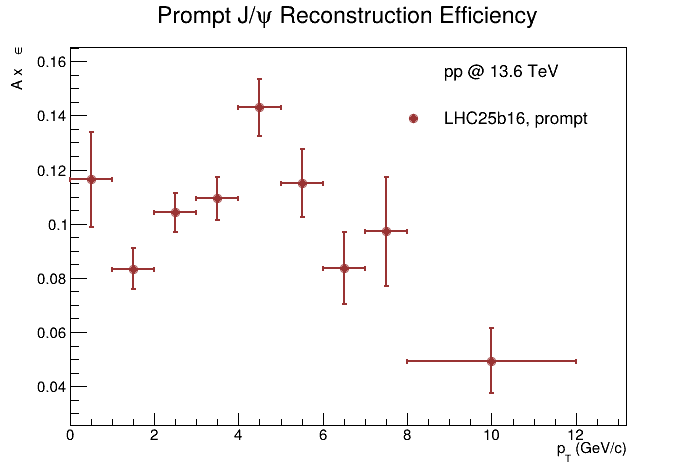

In [6]:
c25b16Prompt = ROOT.TCanvas()
graph25b16Prompt.SetTitle("Prompt J/#psi Reconstruction Efficiency") #Change previous title
graph25b16Prompt.Draw("AP")
leg25b16Prompt.Draw()
c25b16Prompt.Draw()

In [7]:
# Non prompt
graph25b16NonPrompt, leg25b16NonPrompt = EfficiencyPlot(
    a="PairsBarrelSEPMCorrectAssoc_jpsiO2MCdebugCuts14_eePrimaryFromNonPromptJPsi",
    b="MCTruthGenSel_nonPromptJpsi",
    path=path,
    graph_title="Non Prompt J/#psi Reconstruction Efficiency",
    legText="LHC25b16, non-prompt"
)

Error in <TBufferFile::CheckByteCount>: object of class TList read too many bytes: 1417808973 instead of 344067149
Warning in <TBufferFile::CheckByteCount>: TList::Streamer() not in sync with data on file /home/ferrandi/alice/O2Physics/PWGJE/Tasks/JPsiWorkDir/JPsiMC/DQEfficiency/LHC25b16_MCSignals25-08-25.root, fix Streamer()


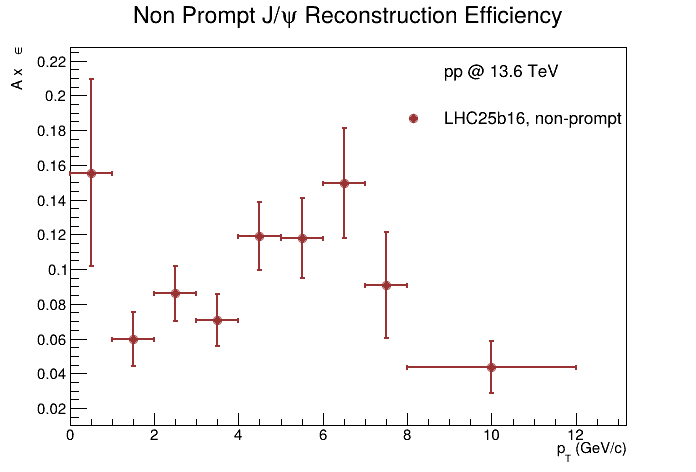

In [8]:
c25b16NonPrompt = ROOT.TCanvas()
graph25b16NonPrompt.SetTitle("Non Prompt J/#psi Reconstruction Efficiency")
graph25b16NonPrompt.Draw("AP")
leg25b16NonPrompt.Draw()
c25b16NonPrompt.Draw()

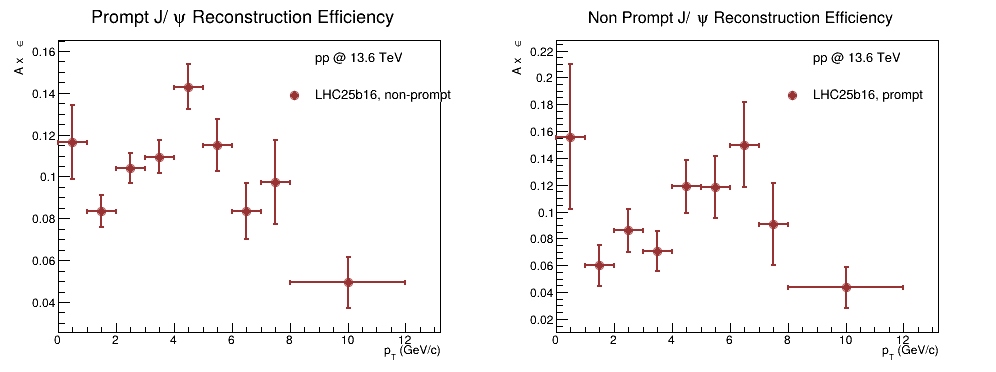

In [9]:
graphs = [graph25b16Prompt, graph25b16NonPrompt]
legends = [leg25b16NonPrompt, leg25b16Prompt]

n = len(graphs)
cAll = ROOT.TCanvas("c", "Side by Side", 500*n , 400)

cAll.Divide(n, 1)
for i, (g, leg) in enumerate(zip(graphs, legends), start=1):
    cAll.cd(i)
    g.Draw("AP")
    leg.Draw()

cAll.Draw()

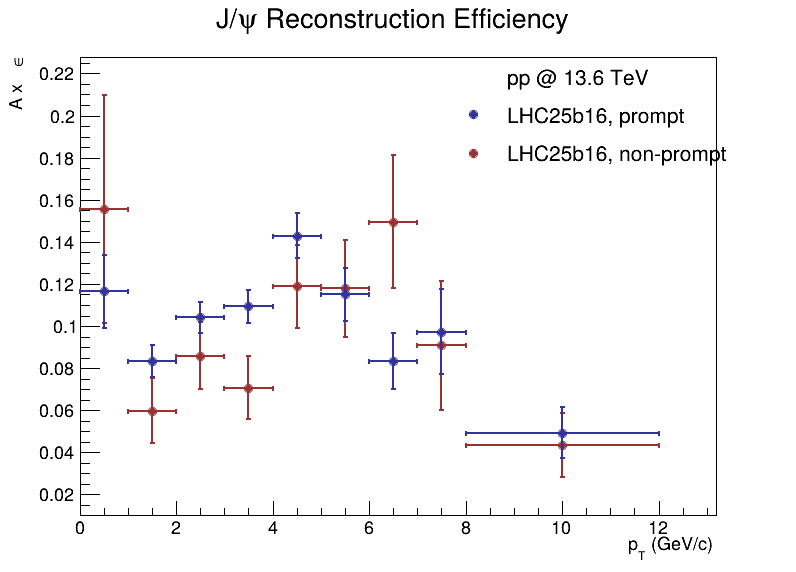

In [10]:
c25b16 = ROOT.TCanvas("b16c", "b16c", 800, 600)
graph25b16Prompt.SetLineColor(ROOT.kBlue-2)
graph25b16Prompt.SetMarkerColor(ROOT.kBlue-2)
graph25b16NonPrompt.SetTitle("J/#psi Reconstruction Efficiency")
graph25b16NonPrompt.Draw("AP") # graph with greater axis must be drawn first
graph25b16Prompt.Draw("P SAME")
leg25b16 = leg25b16Prompt.Clone("leg25b16")
# legendPrompt.Draw()
leg25b16.AddEntry(graph25b16NonPrompt, "LHC25b16, non-prompt", "p")
leg25b16.Draw()
c25b16.Draw()